In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Implementing Neural Networks with Pytorch

### NNs and NN Layers:

A basic feedforward neural network (NN) is a function $\varphi: \mathbb{R}^{n_0} \to \mathbb{R}^{n_{\ell}}$ consisting of $\ell$ layers

* layer - affine function $f_i : \mathbb{R}^{n_i} \to \mathbb{R}^{n_{i+1}}$ of the form $f_i(x) = xA_i^T + b_i$

and activation functions

* activation function - nonlinear nondecreasing map $\sigma_i: \mathbb{R} \to \mathbb{R}$ (often sigmoid, tanh, ReLU, etc...)

The NN itself is a composition of all of the layers interleaved with their corresponding activation functions
$$
    \varphi(x) := \left(\sigma_{\ell -1}\circ f_{\ell -1} \circ \dots \circ \sigma_0 \circ f_0 \right) (x)
$$

Often, $\sigma_{\ell - 1}$ is left out or taken to be the identity function so as not to bound the final output.

### Important Facts about NNs

* A NN is completely parameterized by the entries of $A_i$ and $b_i$, so we call these entries the "weights" of the NN.

* NNs are universal approximators in the sense that, given a sufficiently large number of layers, any continuous function on a compact set can be approximated to arbitrary accuracy by a NN (see the various universal approximation theorems).

### Creating NN Layers with the `torch.nn` Submodule

In [41]:
# Create an NN layer of the form f(x) = x A^T + b

layer = nn.Linear(2, 3)
layer

Linear(in_features=2, out_features=3, bias=True)

In [43]:
# Inspect the parameters

list(layer.parameters())

[Parameter containing:
 tensor([[-0.3951, -0.3231],
         [-0.3878, -0.6659],
         [-0.1776,  0.0598]], requires_grad=True),
 Parameter containing:
 tensor([-0.4632, -0.0533, -0.5035], requires_grad=True)]

### Tensor dimensions are important!

In [44]:
# Evaluate the layer at some input (last dimension should be 2)

x = torch.tensor([1.0, 2.0])
out = layer(x)
out

tensor([-1.5045, -1.7728, -0.5616], grad_fn=<AddBackward0>)

In [13]:
# Sum up the output of the layer and call `backward` to accumulate gradients

summed_out = torch.sum(out)
print(summed_out)

summed_out.backward()

tensor(0.0465, grad_fn=<SumBackward0>)


In [14]:
# Inspect the gradients of the layer parameters

for param in layer.parameters():
    print(param.grad)

tensor([[1., 2.],
        [1., 2.],
        [1., 2.]])
tensor([1., 1., 1.])


### Using the `nn.Module` Class to Make Custom NNs

In [45]:
# Implement simple feedforward NN

class NN(nn.Module):
    
    def __init__(self, in_dims, out_dims):
        super().__init__()
        self.layer1 = nn.Linear(in_dims, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, out_dims)
        self.activation = nn.Tanh()
        
    def forward(self, x):
        x = self.activation( self.layer1(x) )
        x = self.activation( self.layer2(x) )
        x = self.layer3(x)
        return x

In [16]:
# Instantiate NN and inspect its parameters

my_nn = NN(2, 1)
print(my_nn)

list(my_nn.parameters())

NN(
  (layer1): Linear(in_features=2, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=1, bias=True)
  (activation): Tanh()
)


[Parameter containing:
 tensor([[-0.5205,  0.5790],
         [ 0.4178, -0.0711],
         [-0.4373, -0.1805],
         [-0.6452,  0.5814],
         [-0.0493, -0.3376],
         [ 0.1400,  0.1773],
         [ 0.0499,  0.2542],
         [ 0.0370,  0.3834],
         [ 0.5028, -0.4078],
         [-0.6641,  0.0350],
         [-0.2555, -0.2072],
         [ 0.3301, -0.5749],
         [-0.6591,  0.4168],
         [ 0.5356, -0.6591],
         [ 0.3949, -0.5198],
         [-0.4993,  0.5474],
         [-0.1953, -0.5399],
         [-0.3015,  0.3006],
         [ 0.1972, -0.0698],
         [ 0.0440, -0.5749],
         [-0.5041, -0.5943],
         [ 0.6955, -0.6946],
         [-0.2042, -0.4289],
         [ 0.1713, -0.6500],
         [ 0.2391, -0.4038],
         [ 0.1633,  0.4775],
         [ 0.2573, -0.0942],
         [ 0.2359,  0.5779],
         [-0.4891, -0.1044],
         [ 0.2791,  0.2607],
         [-0.5643,  0.6817],
         [-0.6627, -0.2282]], requires_grad=True),
 Parameter containing:
 ten

In [17]:
# Evaluate the NN at some input

my_nn(x)

tensor([0.0942], grad_fn=<AddBackward0>)

### Fitting Your NN to a 2D Gaussian

How good is our NN at approximating a nonlinear function like a Gaussian?

$$
    f(x,y) = \exp(-(x^2 + y^2))
$$

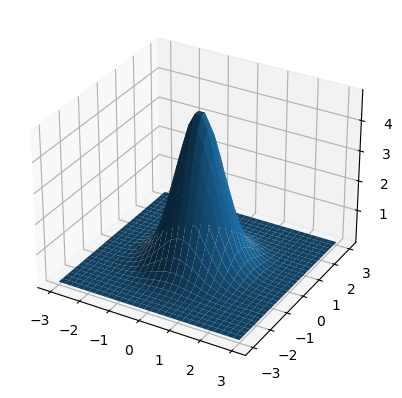

In [32]:
# Define and plot the gaussian

def f(x, y):
    return 5 * torch.exp(-(x**2 + y**2))

x = torch.linspace(-3, 3, 30)
y = torch.linspace(-3, 3, 30)
X, Y = torch.meshgrid((x, y))

Z = f(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

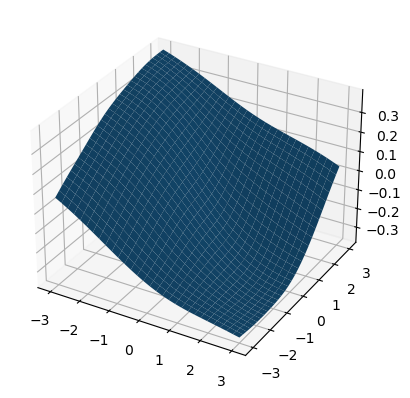

In [47]:
# Instantiate and plot initialized NN

model = NN(2, 1)

# We have to make sure the input to `model` is of the right dimensions
# (the last dimension must be 2)
X_in = X.reshape(-1, 1)
Y_in = Y.reshape(-1, 1)
XY_in = torch.hstack((X_in, Y_in))

with torch.no_grad():
    out = model(XY_in).reshape(30, 30)  # reshape the output or plotting

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, out)

#### Defining the Loss
We would like to minimize the $L^2$ error between our NN output and $f$ on some compact set $\Omega \subset \mathbb{R}^2$:

$$
    \mathcal{L}(\phi) = \iint_\Omega \big[f(x,y) - NN_\phi(x,y) \big]^2 dx\, dy
$$

Equivalently, we can view this through the lens of probability, in which case

$$
    \mathcal{L}(\phi) = \mathbb{E} \big[ (f(X)  - NN_\phi(X))^2 \big]
$$

where $X \sim \mu_{\Omega}$ (normalized Lebesgue measure on $\Omega$).

If $X_1, \dots, X_n$ are i.i.d. samples of distribution $\mu_\Omega$, then

$$
    \hat{\mathcal{L}}(\phi) = \frac{1}{n} \sum_{i=0}^n \big(f(X_i) - NN_\phi (X_i)\big)^2,
$$

the Mean Squared Error (MSE), is an unbiased estimator of $\mathcal{L}$ in the sense that $\mathbb{E} \big[\hat{\mathcal{L}}\big] = \mathcal{L}$. This means we can use $\hat{\mathcal{L}}(\phi)$ as our loss function when trying to minimize $\mathcal{L}(\phi)$.

We'll minimize $\hat{\mathcal{L}}$ using gradient descent:

$$
    \phi^{i+1} = \phi^i - \alpha \nabla_{\phi} \hat{\mathcal{L}}(\phi^i)
$$

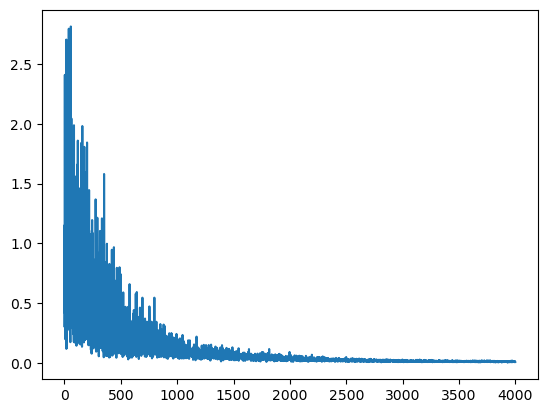

In [48]:
# Set up main training loop

α = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=α)
batch_size = 20
sampler = torch.distributions.uniform.Uniform(-3, 3)

losses = []
for _ in range(4000):
    xy = sampler.sample((batch_size, 2))
    x = xy[:, 0:1]
    y = xy[:, 1:2]
    out = model(xy)
    optimizer.zero_grad()
    loss = torch.mean( (f(x, y) - out)**2 )
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    
plt.plot(losses)

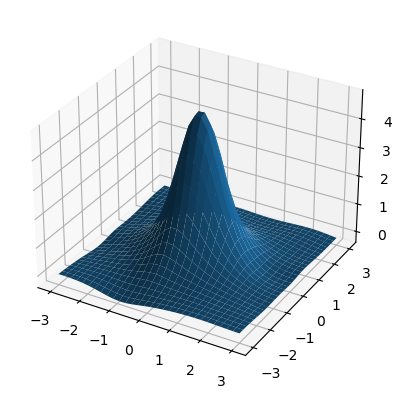

In [49]:
# Plot trained model

with torch.no_grad():
    out = model(XY_in).reshape(30, 30)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, out)

### Saving Your Neural Network

In [36]:
# Save the model

torch.save(model.state_dict(), 'gaussian.pt')

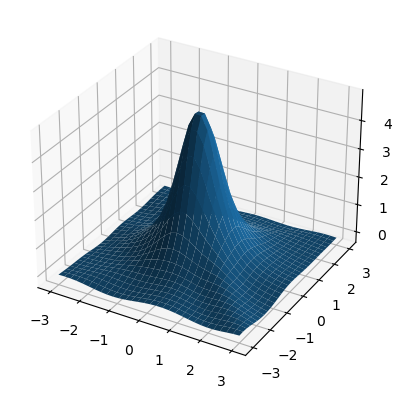

In [37]:
# Load the model

restored_model = NN(2, 1)
restored_model.load_state_dict(torch.load('gaussian.pt'))

with torch.no_grad():
    out = restored_model(XY_in).reshape(30, 30)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, out)